# Libraries

In [ ]:
import numpy as np
import pandas as pd
import math
# Used to save logs on file
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
# Used for L2 regularization
from tensorflow.keras import regularizers
# Used for dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD, Adamax, RMSprop, Adagrad, Adam
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

from keras import backend as K

import tensorflow as tf


from datetime import datetime

# Used for early stopping
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Handling the dataset

In [ ]:
# Read and view TR
# dataset = "cup/ML-CUP20-TR.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TR.csv"

# Column 0:     ID
# Column 1-10:  inputs
# Column 11-12: target_x target_y
train_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
               "input_10", "target_x", "target_y"]
df_train = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=train_names, index_col=0))

# Store the number of training patterns
n_TR_patterns = len(df_train.index)
print(f'N. rows TR: {n_TR_patterns}\n')

# log.write(f'N. rows TR: {n_TR_patterns}\n')

# print(df_train.head())

# Read and view TS
# dataset = "cup/ML-CUP20-TS.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TS.csv"

# Column 0:    ID
# Column 1-10: inputs
test_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
              "input_10"]
df_test = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=test_names, index_col=0))

# Store the number of (blind) testing patterns
n_TS_patterns = len(df_test.index)
print(f'N. rows TS: {n_TS_patterns}\n')

# log.write(f'N. rows TS: {n_TS_patterns}\n')

# print(df_test.head())

N. rows TR: 1524

N. rows TS: 472



#DATA MANIPULATION

In [ ]:
# Divide into TR and (internal) TS
attributes = [col for col in df_train.columns if 'input' in col]

# Separating internal TS from the rest of training dataset (ca. 20%)
print("\ndf_train ", len(df_train))  # 1524

df_subset = df_train.sample(200, random_state=100) #modifico la size del blind test set
print("\ndf_subset ", len(df_subset))  # 304
print(df_subset.head())

df_train = df_train.drop(df_subset.index)
print("\ndf_train after removal ", len(df_train))  # 1220

X_train = df_train[attributes].values
y_train = df_train[['target_x', 'target_y']].values

X_test = df_subset[attributes].values
y_test = df_subset[['target_x', 'target_y']].values

n_features = X_train.shape[1]
print(X_train.shape[0])

print(f'\nN. input features: {n_features}')

# log.write(f'\nN. input features: {n_features}')

# Handle (blind) TS
attributes = [col for col in df_test.columns if 'input' in col]
X_blind_TS = df_test[attributes].values



df_train  1524

df_subset  200
       input_1   input_2   input_3  ...  input_10   target_x   target_y
id                                  ...                                
801   1.155300  0.059795 -0.604900  ...  1.727382  39.929663 -29.595517
720  -0.918605  0.637450  1.347002  ... -0.903759  72.384610 -28.855841
1059 -0.652593  1.394323  0.103282  ... -1.030427  52.796461 -39.445597
189   1.439956 -0.605409 -0.758339  ...  1.819379  40.553341 -30.551312
229   0.915644 -1.250489 -1.028318  ...  0.055362  31.467524 -13.706777

[5 rows x 12 columns]

df_train after removal  1324
1324

N. input features: 10


# Building the network

In [ ]:
def mee_keras(y_true, y_pred):
  return K.mean(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True)))

In [ ]:
def r2_keras(y_true, y_pred):
  SS_res = K.sum(K.square(y_true-y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1 - SS_res/(SS_tot + K.epsilon()))

In [ ]:
# Construction of the Neural Network
# Units input layer
# units_in = 6
# Units hidden layer
# units_hid = 4


def build_model(neurons=1, dropout_rate=0.0, weight_constraint=0, activation='sigmoid', learn_rate=0.001, momentum=0,
                reg_value=0, optimizer='adam', init_mode='uniform'):
    # Cleanup
    #K.clear_session()
    tf.keras.backend.clear_session()
    # Build the model
    model = Sequential()

    if reg_value != 0:
        # Apply regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_2 = Dense(neurons, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_3 = Dense(2, activation='linear')
    else:
        # No regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation)
        layer_2 = Dense(neurons, activation=activation)
        layer_3 = Dense(2, activation=activation)

    model.add(layer_1)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_2)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_3)

    # Compile the model
    if optimizer == 'SGD':
      # opt = SGD(learning_rate=learn_rate, momentum=momentum)
      # With clipping
      opt = SGD(learning_rate=learn_rate, momentum=momentum, clipnorm=1.0)
    elif optimizer == 'Adamax':
      # opt = Adamax(learning_rate=learn_rate, name="Adamax")
      # With clipping
      opt = Adamax(learning_rate=learn_rate, name="Adamax", clipnorm=1.0)
    elif optimizer == 'RMSprop':
      # With clipping
      opt = RMSprop(learning_rate=learn_rate, rho=0.9, momentum=momentum, 
                    epsilon=1e-07, centered=False, name="RMSprop", clipnorm=1.0)
    elif optimizer == 'Adagrad':
      # With clipping
      opt = Adagrad(learning_rate=learn_rate, initial_accumulator_value=0.1,
                    epsilon=1e-07, name="Adagrad", clipnorm=1.0)
    else: 
      # Adam
      # With clipping
      opt = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-07, amsgrad=False, name="Adam", clipnorm=1.0)
    
    # Metrics: MSE, MEE (manual implementation), R^2 (manual implementation)
    model.compile(loss=MeanSquaredError(),
                  optimizer=opt,
                  # metrics=[tf.keras.metrics.MeanSquaredError()])
                  metrics=[tf.keras.metrics.MeanSquaredError(), mee_keras, 
                           r2_keras]) 

    return model


# Manual initialization

In [ ]:
# Construction of the Neural Network
# Units input layer
# units_in = 6
# Units hidden layer
# units_hid = 4


def build_model(neurons=1, dropout_rate=0.0, weight_constraint=0, activation='sigmoid', learn_rate=0.001, momentum=0,
                reg_value=0, optimizer='adam', init_mode='uniform'):
    # Cleanup
    #K.clear_session()
    tf.keras.backend.clear_session()
    # Build the model
    model = Sequential()

    if reg_value != 0:
        # Apply regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_2 = Dense(neurons, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_3 = Dense(2, activation='linear')
    else:
        # No regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation)
        layer_2 = Dense(neurons, activation=activation)
        layer_3 = Dense(2, activation=activation)

    model.add(layer_1)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_2)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_3)

    # Compile the model
    if optimizer == 'SGD':
      # opt = SGD(learning_rate=learn_rate, momentum=momentum)
      # With clipping
      opt = SGD(learning_rate=learn_rate, momentum=momentum, clipnorm=1.0)
    elif optimizer == 'Adamax':
      # opt = Adamax(learning_rate=learn_rate, name="Adamax")
      # With clipping
      opt = Adamax(learning_rate=learn_rate, name="Adamax", clipnorm=1.0)
    elif optimizer == 'RMSprop':
      # With clipping
      opt = RMSprop(learning_rate=learn_rate, rho=0.9, momentum=momentum, 
                    epsilon=1e-07, centered=False, name="RMSprop", clipnorm=1.0)
    elif optimizer == 'Adagrad':
      # With clipping
      opt = Adagrad(learning_rate=learn_rate, initial_accumulator_value=0.1,
                    epsilon=1e-07, name="Adagrad", clipnorm=1.0)
    else: 
      # Adam
      # With clipping
      opt = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-07, amsgrad=False, name="Adam", clipnorm=1.0)
    
    # Metrics: MSE, MEE (manual implementation), R^2 (manual implementation)
    model.compile(loss=MeanSquaredError(),
                  optimizer=opt,
                  # metrics=[tf.keras.metrics.MeanSquaredError()])
                  metrics=[tf.keras.metrics.MeanSquaredError(), mee_keras, 
                           r2_keras]) 

    return model


In [ ]:
def init_config(units_hid = 10, r = 1/math.sqrt(n_features)):
  config_hid1 = []
  config_hid2 = []
  config_hid3 = []
  # config_hid4 = []
  # config_hid5 = []

  # weights_in = np.random.uniform(-0.2, 0.2, size=(n_features,units_hid))
  weights_in = np.random.uniform(-r, r, size=(n_features,units_hid))
  # bias_in = np.random.uniform(-0.2, 0.2, units_hid)
  if r == 1/math.sqrt(n_features):
    bias_in = np.zeros(units_hid)
  else:
    bias_in = np.random.uniform(-r, r, units_hid)
  config_hid1.append(weights_in)
  config_hid1.append(bias_in)

  # weights_in = np.random.uniform(-0.2, 0.2, size=(n_features,units_hid))
  weights_in = np.random.uniform(-r, r, size=(units_hid,units_hid))
  # bias_in = np.random.uniform(-0.2, 0.2, units_hid)
  if r == 1/math.sqrt(n_features):
    bias_in = np.zeros(units_hid)
  else:
    bias_in = np.random.uniform(-r, r, units_hid)
  config_hid2.append(weights_in)
  config_hid2.append(bias_in)

  # weights_hid = np.random.uniform(-0.3, 0.3, size=(units_hid,1))
  weights_in = np.random.uniform(-r, r, size=(units_hid,2))
  # bias_hid = np.random.uniform(-0.2, 0.2, 1)
  if r == 1/math.sqrt(n_features):
    bias_in = np.zeros(2)
  else:
    bias_in = np.random.uniform(-r, r, 2)
  config_hid3.append(weights_in)
  config_hid3.append(bias_in)

  # return [config_hid1, config_hid2, config_hid3, config_hid4, config_hid5]
  return [config_hid1, config_hid2, config_hid3]
  

In [ ]:
early_val_loss = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=100,
    mode="min",
    restore_best_weights=True,
)

early_val_accuracy = EarlyStopping(
    monitor="val_r2_keras",
    patience=100,
    mode="max",
    restore_best_weights=True,
)


In [ ]:
# Current best model
n_neurons = 200
model = build_model(neurons=n_neurons, dropout_rate=0.0, weight_constraint=1, activation='sigmoid', learn_rate=0.0003, momentum=0.0, reg_value=0.0001, optimizer='Adamax', init_mode='he_uniform')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               2200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 42,802
Trainable params: 42,802
Non-trainable params: 0
_________________________________________________________________


#CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

num_folds = 20
batch_size=80

min_mee = 100

# Define per-fold score containers
mse_per_fold = []
mee_per_fold = []
r2_per_fold = []
loss_per_fold = []

val_mse_per_fold = []
val_mee_per_fold = []
val_r2_per_fold = []
val_loss_per_fold = []


list_of_history = []

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X_train, y_train):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size, validation_split=0.33,
              epochs=500, 
              callbacks=[early_val_accuracy, early_val_loss] 
              )

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)

  #compare mee value on fold test set to select the best submodel
  if min_mee > scores[2]:
    min_mee = scores[2]
    submodel = model
    best_fold = fold_no
  
  loss_per_fold.append(scores[0])
  mse_per_fold.append(scores[1])
  mee_per_fold.append(scores[2])
  r2_per_fold.append(scores[3])

  list_of_history.append(history)

  # Increase fold number
  fold_no = fold_no + 1

Output streaming troncato alle ultime 5000 righe.
11/11 [==============================] - 0s 13ms/step - loss: 7.3005 - mean_squared_error: 7.2603 - mee_keras: 2.9249 - r2_keras: 0.9956 - val_loss: 7.3803 - val_mean_squared_error: 7.3401 - val_mee_keras: 2.9044 - val_r2_keras: 0.9958
Epoch 462/500
11/11 [==============================] - 0s 13ms/step - loss: 7.3033 - mean_squared_error: 7.2631 - mee_keras: 2.8899 - r2_keras: 0.9957 - val_loss: 7.3891 - val_mean_squared_error: 7.3489 - val_mee_keras: 2.9086 - val_r2_keras: 0.9958
Epoch 463/500
11/11 [==============================] - 0s 16ms/step - loss: 7.2979 - mean_squared_error: 7.2577 - mee_keras: 2.9121 - r2_keras: 0.9956 - val_loss: 7.3891 - val_mean_squared_error: 7.3489 - val_mee_keras: 2.9090 - val_r2_keras: 0.9958
Epoch 464/500
11/11 [==============================] - 0s 13ms/step - loss: 7.3062 - mean_squared_error: 7.2660 - mee_keras: 2.9062 - r2_keras: 0.9956 - val_loss: 7.4153 - val_mean_squared_error: 7.3751 - val_mee_k

In [ ]:
print('Best fold model:', best_fold)
print('Min MEE reached:', min_mee)


Best fold model: 8
Min MEE reached: 2.05305552482605


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold - test set')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]} - MEE: {mee_per_fold[i]} - R2: {r2_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(mse_per_fold)}')
print(f'> MEE: {np.mean(mee_per_fold)}')
print(f'> R2: {np.mean(r2_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold - test set
------------------------------------------------------------------------
> Fold 1 - Loss: 10.753973007202148 - MSE: 10.715536117553711 - MEE: 3.8426218032836914 - R2: 0.9921665787696838
------------------------------------------------------------------------
> Fold 2 - Loss: 10.512674331665039 - MSE: 10.473488807678223 - MEE: 3.9477851390838623 - R2: 0.9900745749473572
------------------------------------------------------------------------
> Fold 3 - Loss: 11.9437894821167 - MSE: 11.903945922851562 - MEE: 3.697674036026001 - R2: 0.9933130145072937
------------------------------------------------------------------------
> Fold 4 - Loss: 4.891622543334961 - MSE: 4.851406574249268 - MEE: 2.6962051391601562 - R2: 0.9972090125083923
------------------------------------------------------------------------
> Fold 5 - Loss: 6.178831100463867 - MSE: 6.138613700866699 - MEE: 2.296748399734497 - R2

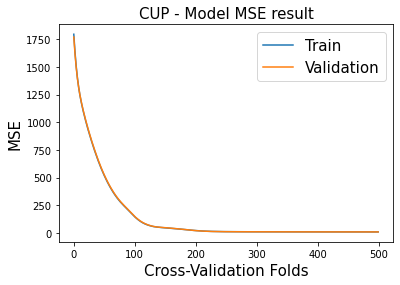

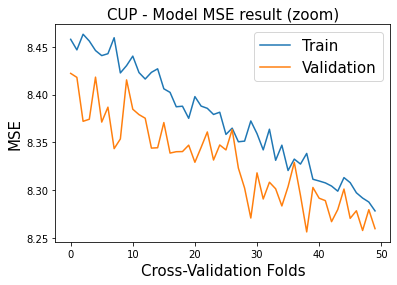

--- --- --- --- --- --- --- --- --- --- --- --- ---


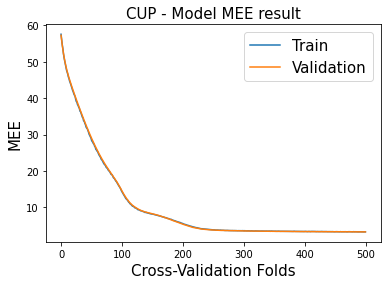

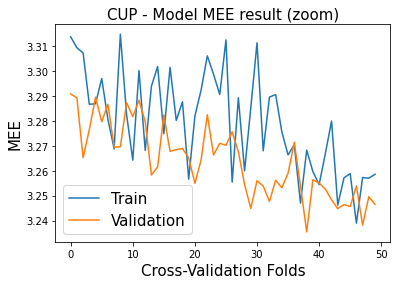

--- --- --- --- --- --- --- --- --- --- --- --- ---


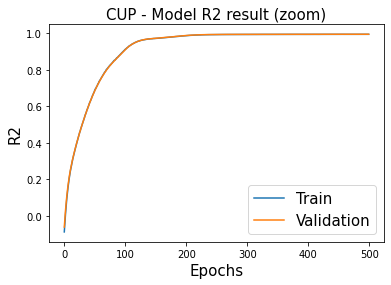

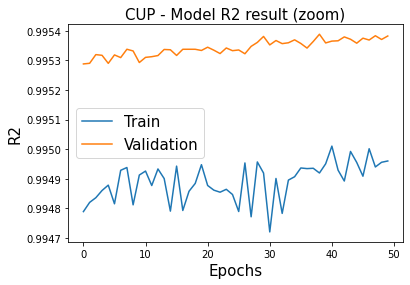

In [ ]:
#plot of the first fold, that shows better the learning curve

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

plt.title('CUP - Model MSE result', fontsize=15)
plt.plot(list_of_history[0].history['mean_squared_error'], label='Train')
plt.plot(list_of_history[0].history['val_mean_squared_error'], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

#get a zoom of last 50 elements
plt.title('CUP - Model MSE result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['mean_squared_error'][-50:], label='Train')
plt.plot(list_of_history[0].history['val_mean_squared_error'][-50:], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('--- --- --- --- --- --- --- --- --- --- --- --- ---')

plt.title('CUP - Model MEE result', fontsize=15)
plt.plot(list_of_history[0].history['mee_keras'], label='Train')
plt.plot(list_of_history[0].history['val_mee_keras'], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MEE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

#get a zoom of last 50 elements
plt.title('CUP - Model MEE result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['mee_keras'][-50:], label='Train')
plt.plot(list_of_history[0].history['val_mee_keras'][-50:], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MEE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('--- --- --- --- --- --- --- --- --- --- --- --- ---')

#plot R2 value for each fold
plt.title('CUP - Model R2 result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['r2_keras'], label='Train')
plt.plot(list_of_history[0].history['val_r2_keras'], label='Validation')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('R2', fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.title('CUP - Model R2 result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['r2_keras'][-50:], label='Train')
plt.plot(list_of_history[0].history['val_r2_keras'][-50:], label='Validation')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('R2', fontsize=15)
plt.legend(fontsize=15)
plt.show()


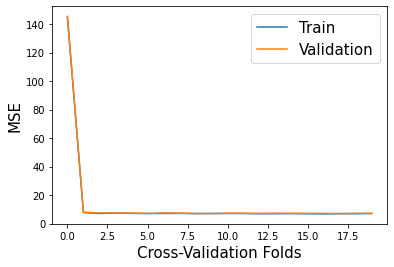

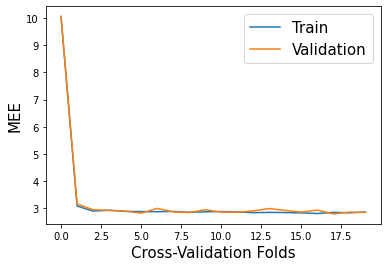

In [ ]:
#plots of average values in CV

mean_val_loss = []
mean_train_loss = []

mean_val_mee = []
mean_train_mee = []

for i in range (num_folds):
  mean_val_loss.append(np.mean(list_of_history[i].history['val_mean_squared_error']))
  mean_train_loss.append(np.mean(list_of_history[i].history['mean_squared_error']))

  mean_val_mee.append(np.mean(list_of_history[i].history['val_mee_keras']))
  mean_train_mee.append(np.mean(list_of_history[i].history['mee_keras']))


plt.plot(mean_train_loss, label='Train')
plt.plot(mean_val_loss, label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.plot(mean_train_mee, label='Train')
plt.plot(mean_val_mee, label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MEE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Final testing

In [ ]:
early_val_loss_test = EarlyStopping(
    monitor="val_loss",
    patience=250,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True,
)

In [ ]:
#retrain the best submodel using entire training set

history = submodel.fit(X_train, y_train, validation_split=0.10, batch_size=batch_size, epochs=30000, callbacks=[early_val_loss_test])

Epoch 1/30000
15/15 [==============================] - 0s 16ms/step - loss: 7.0527 - mean_squared_error: 7.0122 - mee_keras: 2.8711 - r2_keras: 0.9958 - val_loss: 6.7803 - val_mean_squared_error: 6.7398 - val_mee_keras: 2.9163 - val_r2_keras: 0.9958
Epoch 2/30000
15/15 [==============================] - 0s 11ms/step - loss: 7.0633 - mean_squared_error: 7.0227 - mee_keras: 2.8802 - r2_keras: 0.9957 - val_loss: 6.8606 - val_mean_squared_error: 6.8201 - val_mee_keras: 2.9370 - val_r2_keras: 0.9958
Epoch 3/30000
15/15 [==============================] - 0s 11ms/step - loss: 7.0441 - mean_squared_error: 7.0036 - mee_keras: 2.8701 - r2_keras: 0.9958 - val_loss: 6.8405 - val_mean_squared_error: 6.8000 - val_mee_keras: 2.9310 - val_r2_keras: 0.9958
Epoch 4/30000
15/15 [==============================] - 0s 11ms/step - loss: 7.0519 - mean_squared_error: 7.0114 - mee_keras: 2.8729 - r2_keras: 0.9957 - val_loss: 6.8522 - val_mean_squared_error: 6.8117 - val_mee_keras: 2.9305 - val_r2_keras: 0.9958


In [ ]:
# Testing model performance on internal TS
X_test = df_subset[attributes].values
y_test = df_subset[['target_x', 'target_y']].values

TS_results = submodel.evaluate(X_test, y_test, verbose=1)

print('\n---------- Internal TS results ----------')
print(f'Loss: {TS_results[0]} - Metrics - MSE: {TS_results[1]} - MEE: {TS_results[2]} - R2: {TS_results[3]}\n\n\n')

7/7 [==============================] - 0s 4ms/step - loss: 6.3306 - mean_squared_error: 6.2900 - mee_keras: 2.8383 - r2_keras: 0.9962

---------- Internal TS results ----------
Loss: 6.330577850341797 - Metrics - MSE: 6.2900471687316895 - MEE: 2.838308572769165 - R2: 0.996243953704834





# Writing results of the blind test

In [ ]:
# Prediction of values on blind TS
# predictions = L2_model.predict(df_test.values, verbose=0) -> For large scale inputs
predictions = model(df_test.values).numpy()
predictions

array([[ 41.34182  , -33.03803  ],
       [ 67.199814 , -32.482056 ],
       [ 75.14786  , -27.153015 ],
       [ 32.362343 , -17.216736 ],
       [ 65.11329  , -33.47426  ],
       [ 50.564148 , -40.689175 ],
       [ 52.66457  , -39.73504  ],
       [ 50.615726 , -40.76002  ],
       [ 35.595985 , -23.0044   ],
       [ 73.070984 , -28.82735  ],
       [ 29.714819 , -11.330031 ],
       [ 35.807064 , -22.7253   ],
       [ 27.391205 ,  -5.733284 ],
       [ 46.51888  , -40.689953 ],
       [ 70.61713  , -30.298805 ],
       [ 43.892513 , -35.563    ],
       [ 61.20014  , -35.732555 ],
       [ 38.232285 , -27.96582  ],
       [ 76.73542  , -26.236712 ],
       [ 29.88078  , -11.021905 ],
       [ 74.3262   , -27.762924 ],
       [ 45.881794 , -40.588745 ],
       [ 40.557076 , -31.269041 ],
       [ 38.44084  , -28.359402 ],
       [ 73.22086  , -28.46701  ],
       [ 58.150715 , -36.86239  ],
       [ 69.71016  , -30.913357 ],
       [ 29.855116 , -11.401792 ],
       [ 71.81479  ,

In [ ]:
df_test_results = pd.DataFrame(predictions, df_test.index)
df_test_results.to_csv(path_or_buf="/content/drive/My Drive/Machine Learning Project/CUP/broken_brain_ML-CUP20-TS.csv", 
                       sep=',', header=False, index=True, index_label=df_test.index)